In [1]:
from pathlib import Path
from nilearn import datasets, image, plotting, input_data, masking
#from bids import BIDSLayout
from ast import literal_eval
from io import StringIO
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.width', 1000)

from IPython.core.display import display, HTML
display(HTML("<style>"
    + "#notebook { padding-top:0px !important; } " 
    + ".container { width:100% !important; } "
    + ".end_space { min-height:0px !important; } "
    + "</style>"))

/home/chris/miniconda3/envs/linenv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
project_root = Path('/data/MBDU/mid_share')
bids_dir = project_root / 'data/bids_defaced'
derivatives_dir = project_root / 'data/derivatives'
swarm_cmd_dir = project_root / 'swarm/fitlins/swarm_cmds'
sing_img_dir = Path('/data/MBDU/singularity_images/')
image_path = (sing_img_dir/'fmriprep_v20.2.2.simg').as_posix()
fs_licence_path = sing_img_dir/'license.txt'
assert fs_licence_path.exists()
fs_licence_path = fs_licence_path.as_posix()
fitlins_out = derivatives_dir / 'fitlins'
fitlins_run_dir = fitlins_out / 'basic_model'
fmriprep_out = derivatives_dir / 'fmriprep' / 'fmriprepv20.2.2_073021'
nilearn_out = derivatives_dir / 'nilearn'
nilearn_out.mkdir(exist_ok=True)
jobids = {}

AssertionError: 

In [73]:
dat_paths = pd.read_csv(str(fitlins_out / 'model_df.csv'))
rest_paths = dat_paths.loc[dat_paths.task == 'rest'].reset_index(drop=True)
rest_paths['entities'] = rest_paths['entities'].apply(lambda x: literal_eval(x))

database_path='/data/MBDU/mid_share/notebooks/pybids131_with_derivs'
%time layout = BIDSLayout(bids_dir, database_path=database_path, derivatives=fmriprep_out)

CPU times: user 5.91 ms, sys: 928 µs, total: 6.84 ms
Wall time: 7.07 ms


In [317]:
# Only needs to run the first time

#fetch 3d atlas and resample to probabilistic 4d atlas
# basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')
# atlas = image.load_img(basc['scale122'])
# atlas_dat = atlas.get_fdata()
# uvs = np.unique(atlas_dat)
# atlas_in_4d = []
# for uv in uvs:
#     atlas_in_4d.append((atlas_dat == uv).astype(int))
# atlas_4d_dat = np.array(atlas_in_4d)
# atlas_dfs = []
# for ii, aa in enumerate(atlas_in_4d):
#     row = {}
#     row['orig_ind'] = ii
#     row['x_min'], row['y_min'], row['z_min'] = np.array(np.where(aa)).min(1)
#     row['x_max'], row['y_max'], row['z_max'] = np.array(np.where(aa)).max(1)
#     row['x_mean'], row['y_mean'], row['z_mean'] = np.array(np.where(aa)).mean(1)
#     atlas_dfs.append(row)
# atlas_dfs = pd.DataFrame(atlas_dfs)
# atlas_df = atlas_dfs.sort_values('y_min', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index':'new_index'})
# atlas_df['match_ind'] = atlas_df.orig_ind + 1000
# atlas_df['new_index'] +=1
# atlas_df.loc[atlas_df['match_ind'] == 1000, 'new_index']=0
# sorted_dat = atlas_dat + 1000
# for ii, row in atlas_df.iterrows():
#     sorted_dat[sorted_dat == row.match_ind] = row.new_index
# sorted_atlas = image.new_img_like(atlas, sorted_dat, atlas.affine, atlas.header)
# uvs = np.unique(sorted_dat)
# atlas_in_4d = np.zeros(list(atlas.shape) + [len(uvs)-1], dtype=int)
# for ii, uv in enumerate(uvs):
#     if uv != 0:
#         atlas_in_4d[:,:,:,ii-1] = (sorted_dat == uv).astype(int)
# sorted_4d_img = image.new_img_like(atlas,atlas_in_4d, affine=atlas.affine,copy_header=True)

# #resample atlas to proper image size
# row = rest_paths.iloc[0]  
# img = image.load_img(row.file)
# regions_extracted_img = image.resample_to_img(sorted_4d_img,img,interpolation='nearest')

# regions_extracted_img.to_filename(str(nilearn_out / 'basc_122_nearest_atlas.nii.gz'))

NameError: name 'rest_paths' is not defined

In [309]:
#Running on NIH server
atlas_path = nilearn_out / 'basc_122_nearest_atlas.nii.gz'
regions_extracted_img = image.load_img(str(atlas_path))

NameError: name 'nilearn_out' is not defined

In [310]:
#Running on my PC
atlas_path = '/mnt/c/Users/chris/OneDrive - Yale University/NIH/Research/database pub/nilearn/nilearn/basc_122_nearest_atlas.nii.gz'
regions_extracted_img = image.load_img(str(atlas_path))

In [2]:
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')
atlas = image.load_img(basc['scale122'])

In [ ]:
def jobhist(jid):
    jh = !jobhist {jid}
    
    jt = []
    nblanks=0
    for ll in jh:
        if nblanks >=2 and ll != '':
            jt.append(ll)
        if ll == '':
            nblanks+=1
    jhdf = pd.read_csv(StringIO('\n'.join(jt)), delim_whitespace=True)
    states = ["RUNNING", "COMPLETED", "FAILED", "CANCELLED", "TIMEOUT"]
    print("Job statuses:")
    for st in states:
        stdf = jhdf.query('State == @st')
        print(f"{st}: {len(stdf)}")
    return jhdf


def subj_status(jhdf, subjects, statuses):
    if len(jhdf) != len(subjects):
        raise ValueError('jhdf and subjects should have the same length')
    status_runs = np.array(jhdf.loc[jhdf.State.isin(statuses), 'Jobid'].str.split('_').str[1]).astype(int)
    status_subjs = np.array(subjects)[status_runs]
    return status_subjs

def put_back(orig_run_name, run_name, project_root, worked):
    bids_dir = project_root / 'data/bids'
    derivatives_dir = project_root / 'data/derivatives'
    orig_fmriprep_out = derivatives_dir / 'fmriprep' / orig_run_name
    rr_fmriprep_out = derivatives_dir / 'fmriprep' / run_name
    orig_fails = derivatives_dir / 'fmriprep' / (orig_run_name + '_failure_archive')
    assert orig_fails != rr_fmriprep_out
    orig_fails.mkdir(exist_ok=True)
    sing_cmds = []
    for sid in worked:
        rr_out_dir = rr_fmriprep_out / f'sub-{sid}'
        orig_out_dir = orig_fmriprep_out / f'sub-{sid}'
        orig_fail_dir = orig_fails / f'sub-{sid}'
        if orig_out_dir.exists():
            shutil.move(orig_out_dir, orig_fail_dir)
        assert ~orig_out_dir.exists()
        shutil.move(rr_out_dir, orig_out_dir)

def make_path(ents, updates, pattern, mp_dir, build_path, check_exist=False):
    mp_ents = ents.copy()
    mp_ents.update(updates)
    mp_file = mp_dir / build_path(mp_ents, pattern, validate=False, absolute_paths=False)
    mp_file.parent.mkdir(exist_ok=True, parents=True)
    if check_exist and not mp_file.exists():
        raise FileNotFoundError(mp_file.as_posix())
    else:
        assert mp_file.parent.exists()
    return mp_file

In [76]:
# add ts_file path to ppdf
# ts_extract_cc: censor and cosine
# ts_extract_ccmp: censor, cosine, motion, physio
ts_run_name = 'ts_extract_ccmp'
cfds_sel=['censor','cosine','motion','physio']
ts_out = nilearn_out / ts_run_name
ts_out.mkdir(exist_ok=True)

ts_pattern = 'sub-{subject}/ses-{session}/sub-{subject}_ses-{session}_task-{task}_run-{run}_space-{space}_desc-{desc}_{suffix}.{extension}'
ts_updates = {'task':'rest','desc':'basc122', 'suffix':'timeseries', 'extension':'csv'}
rest_paths['rest_ts_path'] = rest_paths.entities.apply(lambda x: make_path(x,
                                                            ts_updates,
                                                            ts_pattern,
                                                            ts_out,
                                                            layout.build_path,
                                                            check_exist=False))

corr_pattern = 'sub-{subject}/ses-{session}/sub-{subject}_ses-{session}_task-{task}_run-{run}_space-{space}_desc-{desc}_{suffix}.{extension}'
corr_updates = {'task':'rest','desc':'basc122', 'suffix':'correlation', 'extension':'csv'}
rest_paths['rest_corr_path'] = rest_paths.entities.apply(lambda x: make_path(x,
                                                            corr_updates,
                                                            corr_pattern,
                                                            ts_out,
                                                            layout.build_path,
                                                            check_exist=False))

In [79]:
def make_extract_command(row):
    cfds = ' -'.join(cfds_sel)
    cmd = f'/data/MBDU/mid_share/env/bin/python3.9 /data/MBDU/mid_share/notebooks/extract_ts.py -img_path {row.file} -mask_path {row.mask_path} -cfds_path {row.cfd_new_path} -atlas_path {atlas_path} -{cfds} -output_path {row.rest_ts_path}'
    return cmd

In [80]:
ts_extract_cmds = list(rest_paths.apply(lambda row: make_extract_command(row), axis=1).values)

In [81]:
run_name = 'nl_ccmp'
swarm_cmd_dir = project_root / 'swarm/nilearn/swarm_cmds'
swarm_cmd_dir.mkdir(exist_ok=True, parents=True)
cmd_file = swarm_cmd_dir / run_name
swarm_log_dir = project_root / 'swarm/nilearn/swarm_logs' / run_name
swarm_log_dir.mkdir(exist_ok=True, parents=True)
cmd_file = Path(cmd_file.as_posix())
cmd_file.write_text('\n'.join(ts_extract_cmds))
tmp = cmd_file.read_text().split('\n')
for i, tt in enumerate(tmp):
    print(tt)
    if i > 5:
        break

/data/MBDU/mid_share/env/bin/python3.9 /data/MBDU/mid_share/notebooks/extract_ts.py -img_path /data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz -mask_path /data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz -cfds_path /data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-20900/out/fmriprep/sub-20900/ses-v1/func/sub-20900_ses-v1_task-rest_run-1_desc-confounds_regressors.tsv -atlas_path /data/MBDU/mid_share/data/derivatives/nilearn/basc_122_nearest_atlas.nii.gz -censor -cosine -motion -physio -output_path /data/MBDU/mid_share/data/derivatives/nilearn/ts_extract_ccmp/sub-20900/ses-v1/sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_desc-basc122_timeseries.csv

In [82]:
jobids[run_name] = ! swarm -f {cmd_file} --gres=lscratch:200 -g 40 -t 5 -b 5 --time 0:10:00 --logdir {swarm_log_dir} --job-name {run_name} --partition quick,norm
jobids[run_name] = jobids[run_name][0]
jobids[run_name]

'20654714'

In [84]:
jhdf = jobhist(20654714)
jhdf

Job statuses:
RUNNING: 0
COMPLETED: 132
FAILED: 0
CANCELLED: 0
TIMEOUT: 0


,Jobid,Partition,State,Nodes,CPUs,Walltime,Runtime,MemReq,MemUsed,Nodelist
0,20654714_0,quick,COMPLETED,1,6,00:50:00,00:11:25,40.0GB/node,13.9GB,cn2630
1,20654714_1,quick,COMPLETED,1,6,00:50:00,00:11:25,40.0GB/node,13.9GB,cn2630
2,20654714_2,quick,COMPLETED,1,6,00:50:00,00:12:09,40.0GB/node,13.9GB,cn2736
3,20654714_3,quick,COMPLETED,1,6,00:50:00,00:11:47,40.0GB/node,14.5GB,cn2736
4,20654714_4,quick,COMPLETED,1,6,00:50:00,00:10:11,40.0GB/node,13.9GB,cn2736
5,20654714_5,quick,COMPLETED,1,6,00:50:00,00:11:54,40.0GB/node,13.9GB,cn2737
6,20654714_6,quick,COMPLETED,1,6,00:50:00,00:11:54,40.0GB/node,14.5GB,cn2737
7,20654714_7,quick,COMPLETED,1,6,00:50:00,00:11:54,40.0GB/node,13.9GB,cn2737
8,20654714_8,quick,COMPLETED,1,6,00:50:00,00:11:49,40.0GB/node,13.9GB,cn2738
9,20654714_9,quick,COMPLETED,1,6,00:50:00,00:11:49,40.0GB/node,13.9GB,cn2738


In [85]:
#make a backup before removing any rows
rest_paths_back = rest_paths.copy()

In [106]:
#run correlations, drop subjects with too few TRs
excluded_scans = pd.DataFrame()
excluded_indices = []
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
for i,row in rest_paths.iterrows():
    try:
        correlation_matrix = correlation_measure.fit_transform([pd.read_csv(row.rest_ts_path,header=None).values])[0]
        pd.DataFrame(correlation_matrix).to_csv(row.rest_corr_path)
    except:
        excluded_scans.append(row)
        excluded_indices.append(i)
rest_paths = rest_paths.drop(excluded_indices)
print(len(rest_paths_back), len(rest_paths), len(excluded_indices))
excluded_scans = rest_paths_back.iloc[excluded_indices]
excluded_scans

658 648 10


,subject,session,task,run,space,suffix,datatype,extension,entities,file,toc_path,mask_path,tsnr_path,events_path,phys1d_path,imgmeta_path,phys_path,physmeta_path,cfd_orig_path,cfd_new_path,nv,ms,has_phys,model_path,subj_out_dir,has_events,rest_ts_path,rest_corr_path
23,22279,v1,rest,2,MNI152NLin2009cAsym,bold,func,nii.gz,"{'subject': '22279', 'session': 'v1', 'task': 'rest', 'run': 2, 'space': 'MNI152NLin2009cAsym', 'suffix': 'bold', 'datatype': 'func', 'extension': 'nii.gz'}",/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22279/out/fmriprep/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22279/out/fmriprep/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_toutcount.txt,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22279/out/fmriprep/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22279/out/fmriprep/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_space-MNI152NLin2009cAsym_res-2_desc-tsnr_bold.nii.gz,/data/MBDU/mid_share/data/bids_defaced/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_events.tsv,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22279/out/fmriprep/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_desc-physregs_timeseries.slibase.1D,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22279/out/fmriprep/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.json,/data/MBDU/mid_share/data/bids_defaced/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_physio.tsv.gz,/data/MBDU/mid_share/data/bids_defaced/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_physio.json,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22279/out/fmriprep/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_desc-confounds_timeseries.tsv,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22279/out/fmriprep/sub-22279/ses-v1/func/sub-22279_ses-v1_task-rest_run-2_desc-confounds_regressors.tsv,16,266918.0,False,/data/MBDU/mid_share/data/derivatives/fitlins/basic_model/sub-22279/ses-v1/run-2/sub-22279_ses-v1_task-rest_run-2_desc-model.json,/data/MBDU/mid_share/data/derivatives/fitlins/basic_model/sub-22279/ses-v1/run-2,False,/data/MBDU/mid_share/data/derivatives/nilearn/ts_extract_ccmp/sub-22279/ses-v1/sub-22279_ses-v1_task-rest_run-2_space-MNI152NLin2009cAsym_desc-basc122_timeseries.csv,/data/MBDU/mid_share/data/derivatives/nilearn/ts_extract_ccmp/sub-22279/ses-v1/sub-22279_ses-v1_task-rest_run-2_space-MNI152NLin2009cAsym_desc-basc122_correlation.csv
57,22892,v2,rest,1,MNI152NLin2009cAsym,bold,func,nii.gz,"{'subject': '22892', 'session': 'v2', 'task': 'rest', 'run': 1, 'space': 'MNI152NLin2009cAsym', 'suffix': 'bold', 'datatype': 'func', 'extension': 'nii.gz'}",/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22892/out/fmriprep/sub-22892/ses-v2/func/sub-22892_ses-v2_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22892/out/fmriprep/sub-22892/ses-v2/func/sub-22892_ses-v2_task-rest_run-1_toutcount.txt,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22892/out/fmriprep/sub-22892/ses-v2/func/sub-22892_ses-v2_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz,/data/MBDU/mid_share/data/derivatives/fmriprep/fmriprepv20.2.2_073021/sub-22892/out/fmriprep/sub-22892/ses-v2/func/sub-22892_ses-v2_task-rest_run-1_space-MNI152NLin2009cAsym_res-2_desc-tsnr_bold.nii.gz,/data/MBDU/mid_share/data/bids_defaced/sub-22892/ses-v2/func/sub-22892_ses-v2_task-rest_run-1_events.tsv,/data/MBDU/mid_share/dat

In [9]:
os.getcwd()

'/mnt/c/Users/chris/OneDrive - Yale University/NIH/Jupyter notebooks'

In [87]:
rest_paths.to_csv(nilearn_out / 'rest_df_ccmp.csv')

In [11]:
rest_paths = pd.read_csv( './rest_df_ccmp.csv')

In [ ]:
pd.read_csv('sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_desc-basc122_correlation.csv')

In [32]:
cor1 = pd.read_csv('/mnt/c/Users/chris/OneDrive - Yale University/NIH/Research/database pub/nilearn/nilearn/ts_extract_ccmp/sub-20900/ses-v1/sub-20900_ses-v1_task-rest_run-1_space-MNI152NLin2009cAsym_desc-basc122_correlation.csv', header = None, index_col = 0)

In [33]:
cor2 = pd.read_csv('/mnt/c/Users/chris/OneDrive - Yale University/NIH/Research/database pub/nilearn/nilearn/ts_extract_ccmp/sub-20900/ses-v4/sub-20900_ses-v4_task-rest_run-1_space-MNI152NLin2009cAsym_desc-basc122_correlation.csv', header = None, index_col = 0)

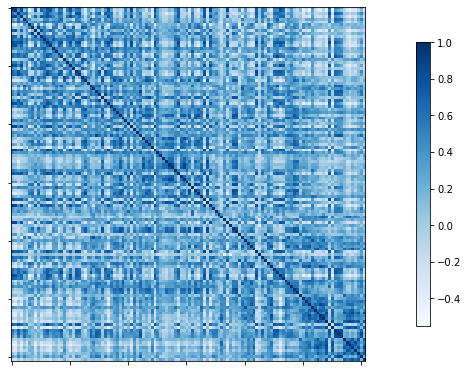

In [34]:
plotting.plot_matrix(cor1,cmap='Blues')

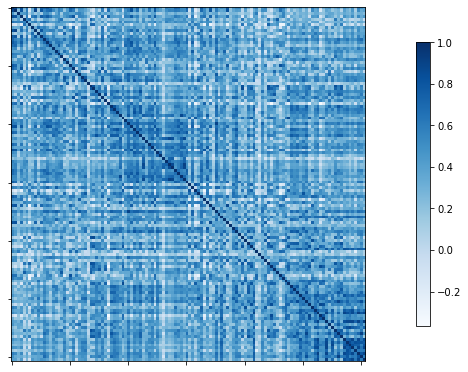

In [31]:
plotting.plot_matrix(cor2,cmap='Blues')